<a href="https://colab.research.google.com/github/Ki-i/APRiL/blob/master/Q3bmse%3D4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


data = pd.read_excel("/content/drive/My Drive/shumo_data/Q3bData.xlsx")
data1 = pd.read_excel('/content/drive/My Drive/shumo_data/附表1-检索表格-流水号vs时间(1).xlsx')
data1=data1.iloc[:, :30]

df3 = pd.read_excel('/content/drive/My Drive/shumo_data/表3-患者影像信息血肿及水肿的形状及灰度分布.xlsx', sheet_name = 'ED')
df4 = pd.read_excel('/content/drive/My Drive/shumo_data/表3-患者影像信息血肿及水肿的形状及灰度分布.xlsx', sheet_name = 'Hemo')
df3 = df3.drop('备注', axis=1)
df4 = df4.drop('备注', axis=1)
df3 = df3.add_suffix('_ED')
df4 = df4.add_suffix('_Hemo')


df3 = df3.rename(columns={"流水号_ED":"流水号"})
df4 = df4.rename(columns={"流水号_Hemo":"流水号"})


# column_names = data.columns.tolist()
# print(column_names)
data = data.fillna(0)
data1 = data1.fillna(0)

data[['高压', '低压']] = data['血压'].str.split('/', expand=True).astype(int)
data = data .drop(columns=["血压"])
data['性别'] = data['性别'].replace({'男': 1, '女': 0})

data = data.rename(columns={"首次检查流水号":"随访0流水号"})
data["随访0间隔时间"]=data["发病到首次影像检查时间间隔"]

data["随访1间隔时间"]=(data1["随访1时间点"] - data1["入院首次检查时间点"])/ pd.Timedelta(hours=1)

for n in range(2,9):
    data[f'随访{n}间隔时间']=0
    for i in range(0,len(data)):
        if data[f'随访{n}流水号'][i]!=0:
            data[f'随访{n}间隔时间'][i]=(data1[f'随访{n}时间点'][i] - data1["入院首次检查时间点"][i])/ pd.Timedelta(hours=1)
            # data[f'差分随访{n}流水号'][i]=(data1[f'随访{n}时间点'][i]- data1[f'随访{n-1}时间点'][i])/ pd.Timedelta(hours=1)

column_names = data.columns.tolist()
# outliers=[80]
# data=data.drop(outliers)
# data1=data1.drop(outliers)
data.head()

ftime=['HM_volume', 'HM_ACA_R_Ratio', 'HM_MCA_R_Ratio', 'HM_PCA_R_Ratio', 'HM_Pons_Medulla_R_Ratio', 'HM_Cerebellum_R_Ratio', 'HM_ACA_L_Ratio', 'HM_MCA_L_Ratio', 'HM_PCA_L_Ratio', 'HM_Pons_Medulla_L_Ratio', 'HM_Cerebellum_L_Ratio', 'ED_volume', 'ED_ACA_R_Ratio', 'ED_MCA_R_Ratio', 'ED_PCA_R_Ratio', 'ED_Pons_Medulla_R_Ratio', 'ED_Cerebellum_R_Ratio', 'ED_ACA_L_Ratio', 'ED_MCA_L_Ratio', 'ED_PCA_L_Ratio', 'ED_Pons_Medulla_L_Ratio', 'ED_Cerebellum_L_Ratio']

check_seq=pd.DataFrame()
check_seq["ID"]=range(1, len(data)*9+1)
check_seq["流水号"]=range(1, len(data)*9+1)
check_seq["time"]=range(1, len(data)*9+1)
for f in ftime:
    check_seq[f]=range(1, len(data)*9+1)
    data = data.rename(columns={f:f"{f}{'.'}{0}"})


pos=0
for i in range(0,len(data)):
    for n in range(0,9):
        check_seq["ID"][pos]=data["ID"].iloc[i]
        check_seq["流水号"][pos]=data[f'随访{n}流水号'].iloc[i]
        check_seq["time"][pos]=data[f'随访{n}间隔时间'].iloc[i]
        for f in ftime:
            check_seq[f][pos]=data[f"{f}{'.'}{n}"].iloc[i]
        pos=pos+1

# print(check_seq.shape)
check_seq = check_seq.merge( df3, on="流水号",how='left')
check_seq = check_seq.merge( df4, on="流水号",how='left')


# print(check_seq.shape)
# print(len(check_seq.columns))
check_seq = check_seq.fillna(0)
# 指定要保存的文件名
# file_name = './data/Q3b_data.xlsx'  # 文件名可以根据你的需求自定义

# # 将 DataFrame 保存为 Excel 文件
# check_seq.to_excel(file_name, index=False)  # index=False 表示不保存索引列
check_seq=check_seq.drop(columns=["ID","流水号"])
# 标准化输入
scaler = StandardScaler()
check_seq = pd.DataFrame(scaler.fit_transform(check_seq), columns=check_seq.columns)


# 将 check_seq 中的数据每9行形成一个二维矩阵，并拼接成一个三维矩阵
num_rows = len(check_seq)
num_per_matrix = 9

# 计算拼接后的三维矩阵的维度
num_matrices = num_rows // num_per_matrix
if num_rows % num_per_matrix != 0:
    num_matrices += 1

# 初始化一个三维矩阵
matrix_shape = (num_matrices, num_per_matrix, check_seq.shape[1])
result_matrix = np.empty(matrix_shape, dtype=int)

# 填充三维矩阵
for i in range(num_matrices):
    start_index = i * num_per_matrix
    end_index = (i + 1) * num_per_matrix
    matrix_data = check_seq.iloc[start_index:end_index].values
    result_matrix[i] = matrix_data

# 打印结果
# print(result_matrix.shape)
cnn_data=result_matrix[0:100]
print(cnn_data.shape)

y=data["90天mRS"][0:100].tolist()
y = np.array(y)
print(len(y))


<ipython-input-48-78fac053af68>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'随访{n}间隔时间'][i]=(data1[f'随访{n}时间点'][i] - data1["入院首次检查时间点"][i])/ pd.Timedelta(hours=1)
<ipython-input-48-78fac053af68>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'随访{n}间隔时间'][i]=(data1[f'随访{n}时间点'][i] - data1["入院首次检查时间点"][i])/ pd.Timedelta(hours=1)
<ipython-input-48-78fac053af68>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'

(100, 9, 85)
100


In [49]:
# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(cnn_data, y, test_size=0.2, random_state=42)

# 将数据转换为PyTorch张量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).view(-1, 1)  # 将目标数据调整为列向量
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).view(-1, 1)  # 将目标数据调整为列向量
# transforms.Normalize(mean=, norm_std)

X_train=torch.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1],X_train.shape[2]))
X_test=torch.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1],X_test.shape[2]))

# X_train=torch.reshape(X_train,(1,X_train.shape[0], X_train.shape[1]))
# X_test=torch.reshape(X_test,(1,X_test.shape[0],  X_test.shape[1]))


# print(X_train.size())
# print(X_test.size())

[1. 3. 1. 2. 1. 1. 1. 3. 1. 4. 1. 4. 0. 4. 2. 3. 6. 1. 1. 0.]
80
20
torch.Size([80, 1, 9, 85])
torch.Size([20, 1, 9, 85])


In [86]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1,16,5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv1d(16,32,2)
        # self.fc1 = nn.Linear(32 * 64, 64)  # 根据输入大小调整线性层的输入大小
        self.flat1 = nn.Flatten()
        self.fc2 = nn.Linear(1280, 1)  # 输出一个连续的回归值
        self.dropout = nn.Dropout(p=0.5)  # dropout训练

    def forward(self, x):
        y = self.conv1(x)
        # print(y.size())
        y = self.relu1(y)
        # print(y.size())
        y = self.pool1(y)
        # print(y.size())
        y = self.flat1(y)
        y = self.dropout(y)
        # print(y.size())
        y = self.fc2(y)

        return y

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch [5001/10000], train_Loss: 0.04663267731666565,test_Loss:7.77875280380249, r2_store:-0.43819608119425735
Epoch [5002/10000], train_Loss: 0.052096735686063766,test_Loss:6.656681060791016, r2_store:-0.2852745948068951
Epoch [5003/10000], train_Loss: 0.03898504376411438,test_Loss:7.599637031555176, r2_store:-0.4191456033271148
Epoch [5004/10000], train_Loss: 0.02619791589677334,test_Loss:6.873024940490723, r2_store:-0.32854014825482025
Epoch [5005/10000], train_Loss: 0.00836271233856678,test_Loss:7.141001224517822, r2_store:-0.3553942397959331
Epoch [5006/10000], train_Loss: 0.000772674276959151,test_Loss:7.2914137840271, r2_store:-0.376293688379173
Epoch [5007/10000], train_Loss: 0.004890958312898874,test_Loss:6.789834499359131, r2_store:-0.3109647544401586
Epoch [5008/10000], train_Loss: 0.014188094064593315,test_Loss:7.579410552978516, r2_store:-0.41139007473243705
Epoch [5009/10000], train_Loss: 0.022541839629411697,test_Loss:6.8267621994018555, r2_stor

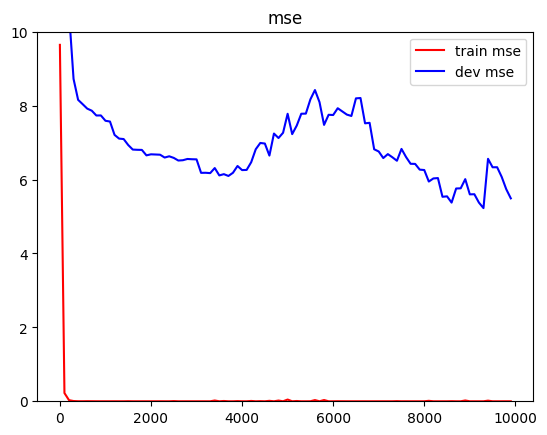

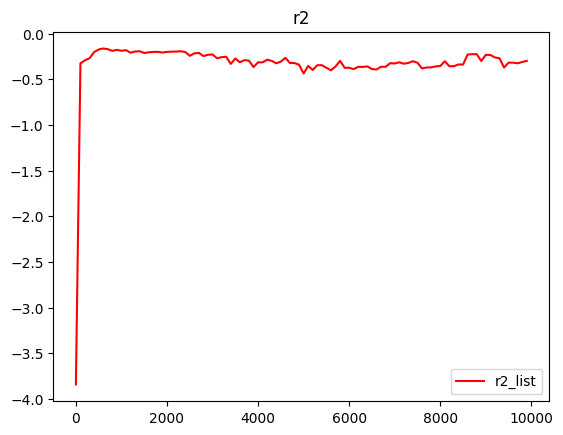

In [87]:
torch.manual_seed(42)

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(cnn_data, y, test_size=0.2, random_state=30)

# 将数据转换为PyTorch张量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).view(-1, 1)  # 将目标数据调整为列向量
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).view(-1, 1)  # 将目标数据调整为列向量
# transforms.Normalize(mean=, norm_std)

X_train=torch.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1],X_train.shape[2]))
X_test=torch.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1],X_test.shape[2]))

model = CNNModel()
# model= D1CNN()
# 定义均方误差损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# 训练模型
num_epochs = 10000
num_plot=100
train_plot=[]
dev_plot=[]
r2_list=[]
step=int(num_epochs/num_plot)
for epoch in range(num_epochs):
    # print(X_train.size())
    # 前向传播
    outputs = model(X_train)
    # print(X_train.size())
    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 测试模型
    model.eval()
    # print("1")
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        r2 = r2_score(test_outputs, y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_Loss: {loss.item()},test_Loss:{test_loss.item()}, r2_store:{r2}')
        if epoch%step==0:
          train_plot.append(loss.item())
          dev_plot.append(test_loss.item())
          r2_list.append(r2)
    # print(f'Test Mean Squared Error (MSE): {test_loss.item()}')

t = list(range(1, num_epochs + 1, step))
plt.title('mse')
plt.plot(t, train_plot, color='red', label='train mse')
plt.plot(t, dev_plot, color='blue', label='dev mse')

plt.legend()
plt.ylim(0,10)
plt.show()

plt.title('r2')
plt.plot(t, r2_list, color='red', label='r2_list')
plt.legend()
# plt.ylim(0,10)
plt.show()